# Реализация парсера

In [ ]:
# -*- coding: utf-8 -*-

# Библиотека для сохранения csv файлов
import csv
# Библиотека для выполнения запросов к WEB-страницам
import requests
# Библиотека для анализа HTML-кода WEB-страниц
from bs4 import BeautifulSoup

# Адрес группы автомобилей для парсинга
URL = "https://auto.ru/cars/bmw/all/"
# Заголовки для маскировки программы-парсера (чтобы сайт не воспринял ее как бота и не заблокировал)
HEADERS = {'user-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36"}
# Названия файла, куда будут сохраняться данные, полученные при парсинге
FILE = "dataset.csv"


# Функция, выполнящая GET-запрос к WEB-странице и получающая ее HTML-код
def get_html(url, params=None):
    r = requests.get(url, headers=HEADERS, params=params)
    # Указание на кодировку, чтобы русские буквы воспринимались так, как они есть
    r.encoding = "utf-8"
    return r


# Функция, получающая количество страниц в группе автомобилей, анализируя пагинация
def get_pages_count(html):
    soup = BeautifulSoup(html, "html.parser")
    # Переменная, хранящая пагинацию страниц (т.е. ссылки, в которых хранятся номера страниц)
    pagination = soup.find_all('a', class_="Button Button_color_whiteHoverBlue Button_size_s Button_type_link Button_width_default ListingPagination-module__page")
    # Если пагинация нашлась - необходимо взять -1 (последний элемент) пагинации, там самым получив элемент, хранящий номер последней страницы
    if pagination:
        return int(pagination[-1].find('span', class_="Button__text").get_text())
    # В ином случае пагинация не существует, т.е. на странице не было найдено ссылок на другие страницы, а значит данная группа автомобилей представлена на всего одной странице
    else:
        return 1


# Функция получения дочернего контента
def get_child_content(URL):
    # Получаем HTML-код из GET-запроса
    html = get_html(URL).text
    # Указание на парсер (парсинг HTML - страницы)
    child_soup = BeautifulSoup(html, 'html.parser')
    # Объект парсинга (контент дочерней страницы)
    item = child_soup.find('div', class_="content")
    # На сайте реализовани 2 вида страниц объявлений (для физических лиц и для юридических лиц)
    try:
        # Попытка парсинга страницы объявления физического лица
        color = item.find('li', class_="CardInfoRow CardInfoRow_color").find('a',class_="Link Link_color_black").get_text()
        drive_unit = item.find('li', class_="CardInfoRow CardInfoRow_drive").find_all('span', class_="CardInfoRow__cell")[-1].get_text()
        tax = item.find('li', class_="CardInfoRow CardInfoRow_transportTax").find_all('span', class_="CardInfoRow__cell")[-1].get_text().replace("\xa0", "")[:-7]
        state = item.find('li', class_="CardInfoRow CardInfoRow_state").find_all('span', class_="CardInfoRow__cell")[-1].get_text()
        owners = int(item.find('li', class_="CardInfoRow CardInfoRow_ownersCount").find_all('span', class_="CardInfoRow__cell")[-1].get_text().replace("\xa0", " ").split(" ")[0])
        city = item.find('span', class_="MetroListPlace__regionName MetroListPlace_nbsp").get_text()
    except Exception:
        try:
            # Попытка парсинга страницы объявления юридического лица (поставщика)
            color = item.find('li', class_="CardInfoGrouped__row CardInfoGrouped__row_color").find('a', class_="Link CardInfoGrouped__cellValue").get_text()
            drive_unit = item.find('li', class_="CardInfoGrouped__row CardInfoGrouped__row_drive").find_all('div', class_="CardInfoGrouped__cellValue")[-1].get_text()
            tax = item.find('li', class_="CardInfoGrouped__row CardInfoGrouped__row_transportTax").find_all('div', class_="CardInfoGrouped__cellValue")[-1].get_text().replace("\xa0", "")[:-7]
            # Автомобиль, который продает поставщик априори не требует ремонта
            state = "Не требует ремонта"
            # Автомобиль, который продает поставщик априори не имел владельцев
            owners = 0
            city = item.find('span', class_="MetroListPlace__regionName MetroListPlace_nbsp").get_text()
        except Exception:
            # Обращение к странице автомобиля, который был продан в момент парсинга
            color = "Не удалось получить данные"
            drive_unit = "Не удалось получить данные"
            tax = "Не удалось получить данные"
            state = "Не удалось получить данные"
            owners = "Не удалось получить данные"
            city = "Не удалось получить данные"
    return [color, drive_unit, tax, state, owners, city]


# Функция получения контента из карточки объяекта
def get_content(html):
    # Указание на парсер (парсинг HTML - страницы)
    soup = BeautifulSoup(html, 'html.parser')
    # Объекты парсинга (карточки автомобилей)
    items = soup.find_all('div', class_="ListingItem-module__main")
    # Массив, в котором будем хранить словари, характеризующие каждый автомобиль
    cars = []
    # Порядковый номер автомобиля на странице, парсинг которого выполняется (для анализа прогресса парсинга)
    k = 1
    # Цикл перебора карточек на странице
    for item in items:
        print(f"Выполняется парсинг {k} автомобиля")
        k += 1
        # Получение ссылки
        href = item.find('a', class_="Link ListingItemTitle-module__link").get('href')
        # На сайте реализовано 2 вида цен - обычная (серая) и акционная (зеленая). Они хранятся в разных классах, соответствественно реализуем 2 вида парсинга
        if item.find('div', class_="ListingItemPrice-module__content"):
            # Попытка паринга неакционной цена
            cost = int("".join(i for i in item.find('div', class_="ListingItemPrice-module__content").get_text() if ord(i) < 128))
        else:
            # Попытка парсинга акционной цены
            cost = item.find('a', class_="Link ListingItemPrice-module__link")
        mileage = item.find('div', class_="ListingItem-module__kmAge").get_text()
        # Если пробег указан как "Новый", то сделаем его нулевым для удобства анализа данных в Pandas
        if mileage == "Новый":
            mileage = 0
        else:
            mileage = int(mileage.replace("&nbsp", "").replace("\xa0", "")[:-2])
        # Выполняется парсинг в глубину, т.е. парсится содержимое со страницы объекта, на которую мы попадаем по ссылке
        child_propeties = get_child_content(href)
        color = child_propeties[0]
        drive_unit = child_propeties[1]
        tax = child_propeties[2]
        state = child_propeties[3]
        owners = child_propeties[4]
        city = child_propeties[5]
        # Заполнение словаря, характеризующего автомобиль
        cars.append({
            # Имя
            'Name': item.find('a', class_="Link ListingItemTitle-module__link").get_text().replace("Рестайлинг", "").replace("  ", " "),
            # Цена
            'Cost': cost,
            # Объем двигателя
            'engine volume': "".join(i for i in item.find('div', class_="ListingItemTechSummaryDesktop__cell").get_text().split('/')[0] if ord(i) < 128)[:-1].replace(".", ","),
            # Лошадиные силы
            'horsepower': "".join(i for i in item.find('div', class_="ListingItemTechSummaryDesktop__cell").get_text().split('/')[1] if ord(i) < 128)[:-2],
            # Вид топлива
            'fuel type': "".join(i for i in item.find('div', class_="ListingItemTechSummaryDesktop__cell").get_text().split('/')[2] if ord(i) > 191).replace("\u2009", "", 1).upper(),
            # Коробка передач
            'Transmission': item.find_all('div', class_="ListingItemTechSummaryDesktop__cell")[1].get_text().upper(),
            # Кузов
            'body': item.find_all('div', class_="ListingItemTechSummaryDesktop__cell")[2].get_text().upper(),
            # Год выпуска
            'year': int(item.find('div', class_="ListingItem-module__year").get_text()),
            # Пробег
            'mileage': mileage,
            # Цвет
            'color': color.upper(),
            # Привод
            'drive_unit': drive_unit.upper(),
            # Налог
            'tax': tax,
            # Состояние
            'state': state.upper(),
            # Владельцы
            'owners': owners,
            # Город
            'city': city.upper(),
            # Ссылка
            'href': href
        })
    return cars


# Функция сохранения полученного датасета в csv файл
def save_file(items, path):
    # Будем использовать контекстный менеджер with-open, для избавления от риска повреждения файла (повредить датасет на 3800 строк - обидно)
    with open(path, 'w', newline="") as file:
        # Укзываем разделитель ";" вместо стандартной "," для более корректной работы
        writer = csv.writer(file, delimiter=";")
        # Запись заголовков в датасет
        writer.writerow(["Марка", "Стоимость", "Объем двигателя", "Лошадиные силы", "Вид топлива", "Коробка передач", "Кузов","Год выпуска", "Пробег", "Цвет", "Привод", "Налог", "Состояние", "Количество владельцев", "Город", "Ссылка"])
        # Перебор массива словарей с автомобилями и запись каждого столбца из словаря
        for item in items:
            writer.writerow([item["Name"], item["Cost"], item["engine volume"], item["horsepower"], item["fuel type"], item["Transmission"], item["body"], item["year"], item["mileage"], item["color"], item["drive_unit"], item["tax"], item["state"], item["owners"], item["city"], item["href"]])


# Основная функция - функция парсинга
def parse():
    # Получение HTML страницы групппы автомобилей
    html = get_html(URL)
    # Проверка корректности подключения к странице
    if html.status_code == 200:
        # Массив, в котором будем хранить словари, характеризующие автомобили
        cars = []
        # Получение количество страниц
        pages_count = get_pages_count(html.text)
        # Перебор страниц всей группы автомобилей
        for page in range(1, pages_count + 1):
            print(f"Парсинг страницы {page} из {pages_count}...")
            # Передача параметров осуществляется в виде словаря, где ключом является значение параметра из адресной строки, а значением - номер страницы
            html = get_html(URL, params={'page': page})
            # Расширение (важно, что расширение, а не добавление) списка словарей, характеризующих автомобили
            cars.extend(get_content(html.text))
        # Сохранение датасета
        save_file(cars, FILE)
    else:
        # Ошибка подключения
        print("Не удалось подключиться к странице")

# Вызов парсера
parse()

# Анализ датасета с помощью Pandas

## Предварительная обработка

### Было принято решение удалить из датасета строки с некорректными значениями, т.к. большинство из некорректных строк - это строки, содержащие проданные на момент парсинга автомобили. Соответственно, по данным автомобилям не удастся получить необходимую информацию (такую как цвет, город, цену и так далее), а значит возникнут ошибки при использовании Pandas и matplotlib

In [14]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Стилизация диаграмм matplotlib

# Стиль диаграммы
plt.style.use('seaborn-whitegrid')
# Размер шрифта у подписей на диаграмме
matplotlib.rcParams.update({'font.size': 16})


# Проверка строки на то, что она подходит для аналища
def good_string(s):
    for element in s:
        if element == "" or element == " " or element == "НЕ УДАЛОСЬ ПОЛУЧИТЬ ДАННЫЕ":
            return False
    return True


# Считывание датасета
df = pd.read_csv('dataset.csv', sep=';', encoding='cp1251')
# Неподходящие строки
bad_strings = []
# Получение списка неподходящих строк
for i in range(df.shape[0]):
    s = df.iloc[i]
    if not good_string(s):
        bad_strings.append(i)
# Удаление неподходящих строк
df.drop(df.index[bad_strings], inplace=True)

# Конвертация в числа
df["Стоимость"] = pd.to_numeric(df["Стоимость"])
df["Налог"] = pd.to_numeric(df["Налог"])
df["Количество владельцев"] = pd.to_numeric(df["Количество владельцев"])

## Создание новых признаков

### Добавление в датафрейм срока эксплуатации автомобиля

In [15]:
# Анализ возраста автомобиля
now = datetime.datetime.now()
now_year = now.year
years = df["Год выпуска"]
ages = [now_year - year for year in years]
df.insert(8, column="Возраст автомобиля", value=ages)

### Добавление в датафрейм категории износа автомобиля

In [26]:
wear_rate = []
for element in df["Возраст автомобиля"]:
    if element <= 5:
        wear_rate.append("Слабый износ")
    elif element <= 9:
        wear_rate.append("Средний износ")
    else:
        wear_rate.append("Высокий износ")
df.insert(9, column="Износ автомобиля", value=wear_rate)

### Добавление в датафрейм категории пробега автомобиля

In [16]:
# Анализ пробега автомобиля
mileage_rate = []
for i in range(df.shape[0]):
    normal = df["Возраст автомобиля"].iloc[i] * 30000
    mileage = df["Пробег"].iloc[i]
    if mileage == 0:
        mileage_rate.append("Не был в прокате")
    elif mileage <= normal:
        mileage_rate.append("Пробег в пределах нормы")
    else:
        mileage_rate.append("Автомобиль работал на износ (возможно такси)")
df.insert(11, column="Активность использования автомобиля", value=mileage_rate)

## Визуализация

### Построение круговой диаграммы количества владельцев

(-1.1267867860998222,
 1.1012755612428486,
 -1.1044187986021126,
 1.1199884949018264)

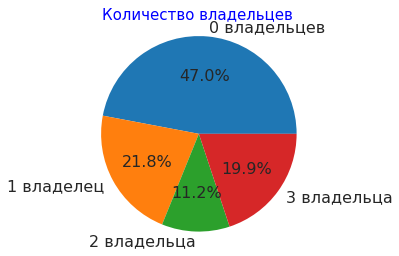

In [17]:
#  КОЛИЧЕСТВО ВЛАДЕЛЬЦЕВ
labels = ["0 владельцев", "1 владелец", "2 владельца", "3 владельца"]
vals = [df["Количество владельцев"].value_counts()[0], df["Количество владельцев"].value_counts()[1], df["Количество владельцев"].value_counts()[2], df["Количество владельцев"].value_counts()[3]]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.set_title("Количество владельцев", fontsize=15, color="blue")
ax.axis("equal")

### Гипотеза: Большинство автомобилей BMW сайта auto.ru поставляются диллерами. Огромная часть объявлений (почти 20%) - это объявления о продаже автомобилей с тремя владельцами. Покупатель имеет риск получать сильной эксплуатированный автомобиль

### Построение гистограммы цветов автомобилей

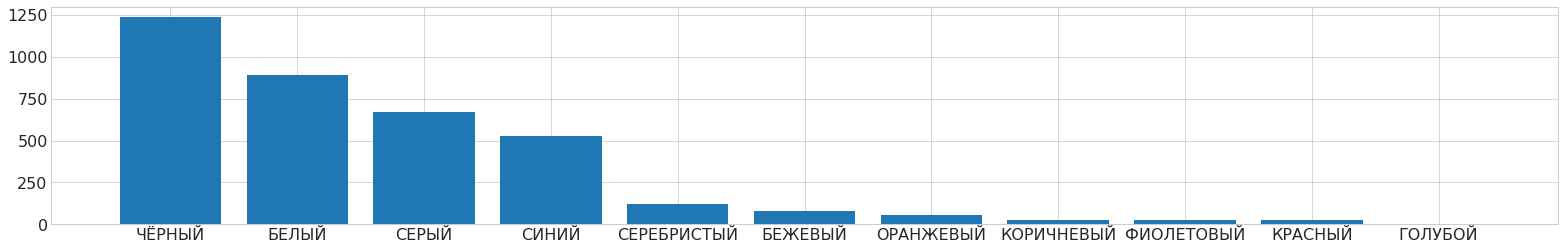

In [18]:
# ЦВЕТА АВТОМОБИЛЕЙ
unique_colors = pd.DataFrame(df["Цвет"].value_counts().to_frame()).index.tolist()
values = [df["Цвет"].value_counts()[i] for i in range(len(unique_colors))]
fig, ax = plt.subplots()
ax.bar(unique_colors, values)
fig.set_figwidth(27)

### Гипотеза: Среди владельцев BMW при выборе цвета с большим отрывом лидирует черный цвет, и менее всех популярен голубой цвет (всего 23 автомобиля)

### Построение круговой диаграммы распределения по категориям пробега автомобиля

(-1.1258969218972195,
 1.1012331867570104,
 -1.1267253964311519,
 1.1210507138460664)

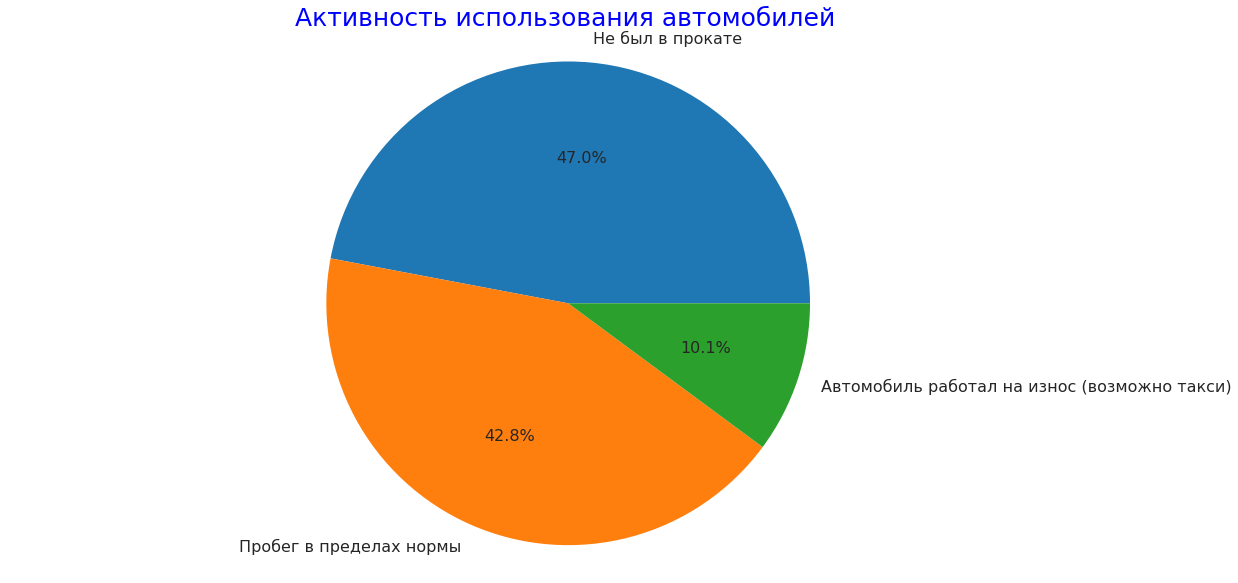

In [19]:
# АКТИВНОСТЬ ИСПОЛЬЗОВАНИЯ АВТОМОБИЛЕЙ
labels = ["Не был в прокате", "Пробег в пределах нормы", "Автомобиль работал на износ (возможно такси)"]
vals = [df["Активность использования автомобиля"].value_counts()[0],
        df["Активность использования автомобиля"].value_counts()[1],
        df["Активность использования автомобиля"].value_counts()[2]]
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.set_title("Активность использования автомобилей", fontsize=25, color="blue")
ax.axis("equal")

### Гипотеза: 10% рынка BMW сайта auto.ru - это автомобили с большей вероятности побывавшие в эксплуатации таксопарками категории comfort, comfort+ или каршеринг. 43% автомобилей. Данная диаграмма подтверждает гипотезу, высказанную в результате анализа первой диаграммы, о том, что более 40% объявлений сайта auto.ru - объявления от поставщиков.

### Построение круговой диаграммы распределения по категориям износа автомобилей

(-1.1047385234178597,
 1.100225643972279,
 -1.1036918306586576,
 1.1052198874687773)

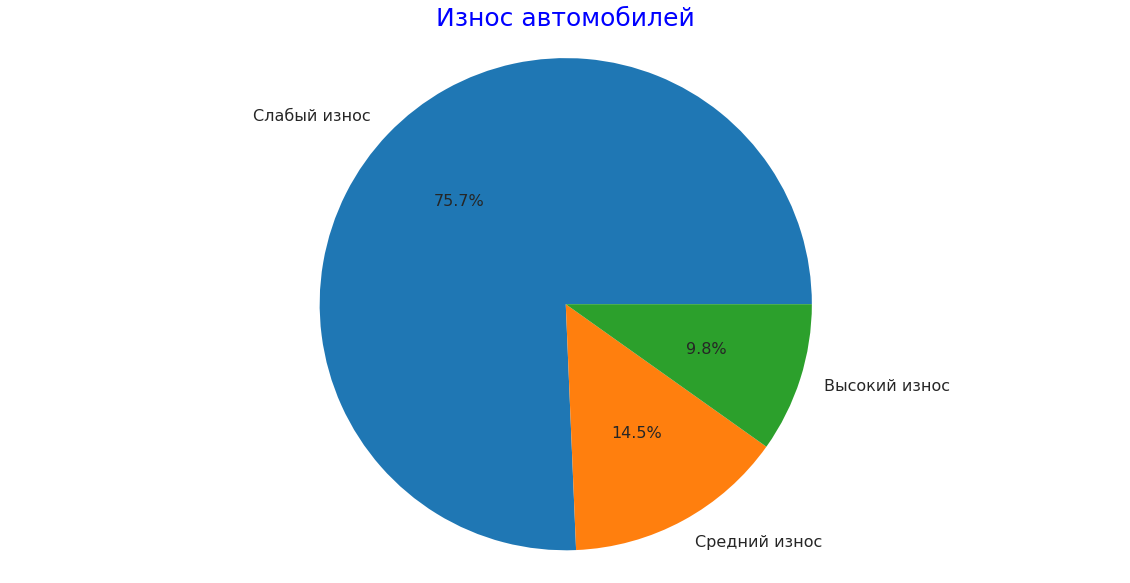

In [28]:
labels = ["Слабый износ", "Средний износ", "Высокий износ"]
vals = [df["Износ автомобиля"].value_counts()[0], df["Износ автомобиля"].value_counts()[1], df["Износ автомобиля"].value_counts()[2]]
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.set_title("Износ автомобилей", fontsize=25, color="blue")
ax.axis("equal")

### Гипотеза: Исходя из вышедоказанной гипотезы о диллерах на сайте auto.ru, около 30% (75.7% - 47%) автомобилей, продающихся на сайте - автомобили, которые эксплуатировались бережно (в основном на небольшие поздки от дома до работы (не более 40-50 км в день)

### Построение круговой диаграммы распределения по городам продажи автомобилей

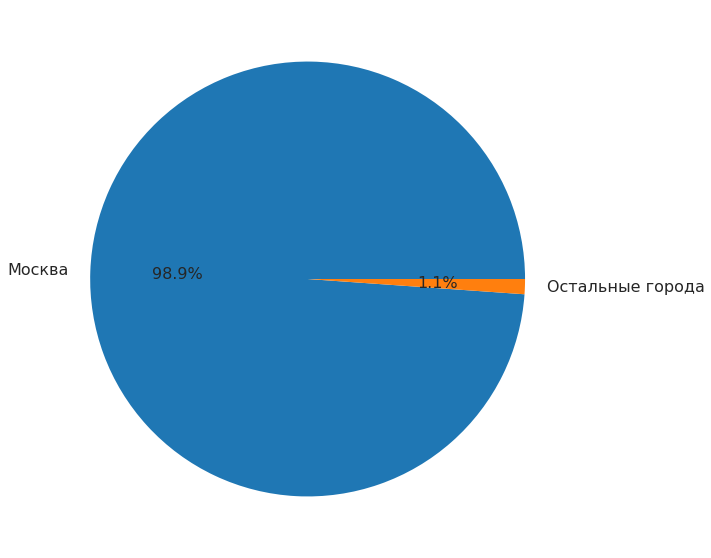

In [21]:
unique_city = pd.DataFrame(df["Город"].value_counts().to_frame()).index.tolist()
moscow_value = df["Город"].value_counts()[0]
last_values = sum([df["Город"].value_counts()[i] for i in range(1, len(unique_city))])
values = [moscow_value, last_values]
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.pie(values, labels=["Москва", "Остальные города"], autopct='%1.1f%%')
fig.savefig("Города продажи автомобилей")

### Гипотеза: Диаграмма, построенная по столбцу "Города" датасета получилась весьма шокирующей. 98.9% рынка BMW на сайте Auto.ru - это автомобили, которые продаются в Москве. И лишь 1.1% - это автомобили, которые продаются в ближайшем подмосковье (Обнинск, Тула, Тверь...). Делаем вывод, что BMW не пользуется популярностью в восточной части России